## MLP  model:

We will first use a very standard precedure to replicate a similar results and then  will make it more detailed in more complicated

### Standard model with parameters set in paper:

#### Import the data:

In [1]:
import pandas as pd

# Load the feature and target data
features = pd.read_csv('features.csv')
targets = pd.read_csv('targets.csv')

In [2]:
# features.head()

#### MLP Model Configuration:

Model uses a 16-12-3-7 architecture shown in Fig.7 with the settings presented in Table.7 down below:

#### Table 7: MLP Parameters

| Parameter Name                | Parameter      |
|-------------------------------|----------------|
| Hidden Layer Number           | 2              |
| Hidden Layer Activation Function | Sigmoid       |
| Output Layer Activation Function | Sigmoid      |
| Learning Rate                 | 0.3            |
| Minimum Performance Gradient  | 1e−5           |
| Performance Goal              | 1e−3           |
| Maximum Number of Epochs to Train | 500        |


In [3]:
from sklearn.neural_network import MLPClassifier

# Configure the MLP Classifier with parameters as per the paper
mlp = MLPClassifier(hidden_layer_sizes=(12, 3), 
                    activation='logistic',  # Sigmoid function is called 'logistic' in sklearn
                    solver='adam', 
                    learning_rate_init=0.3, 
                    tol=1e-5,  # Tolerance for the optimization (Minimum Performance Gradient)
                    max_iter=1000, 
                    random_state=1442)

We are using solver='adam' since it is a very standard solver. Solver type is not defined in the paper.

#### Data Preprocessing and Model Pipeline:

Since the dataset features may have different scales, it's essential to standardize them before training the MLP model.

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Standardizing the feature data and setting up the pipeline
scaler = StandardScaler()
pipeline = make_pipeline(scaler, mlp)

#### Model Training and Validation

Implement 10-fold cross-validation to evaluate the model's performance as suggested in paper.

In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Performing 10-fold stratified cross-validation
cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=1441)
scores = cross_val_score(pipeline, features, targets.values.ravel(), cv=cross_val, scoring='accuracy')

# Calculating the average accuracy
average_accuracy = scores.mean()
print(f"Average Accuracy: {average_accuracy}")

Average Accuracy: 0.9088974268509917


This accuracy value is on par with the value presented in the paper. Lets try to investigate further and produce better results.

In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Define the solvers to test
solvers = ['adam', 'sgd', 'lbfgs']

# Performance goal approximation using 'tol'
performance_goal = 1e-5

# Results dictionary
results = {}

# Standardizing the feature data and setting up the pipeline
scaler = StandardScaler()

# 10-fold Stratified Cross-Validation setup
cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Loop through each solver
for solver in solvers:
    # Configure the MLP Classifier for each solver
    mlp = MLPClassifier(hidden_layer_sizes=(12, 3), activation='logistic', solver=solver,
                        learning_rate_init=0.3, tol=performance_goal, max_iter=500, random_state=42)

    pipeline = make_pipeline(scaler, mlp)

    # Perform cross-validation and store the results
    scores = cross_val_score(pipeline, features, targets.values.ravel(), cv=cross_val, scoring='accuracy')
    results[solver] = scores.mean()

results


/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer

{'adam': 0.9099997734239207,
 'sgd': 0.9213879726943455,
 'lbfgs': 0.9297637890425652}

There is a performance goal parameter mentioned in the paper, which doesn't exist in sklearn model. Closest we have is "tol" parameter in model structure which we implemented. We tried 3 sperate model solvers and realised that 'adam' solver isn't the best option out there for this dataset. So we will make a more detailed anaylsis:

### Detailed analysis:

#### Setup :

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Define solvers and any other models you want to test
models = {
    'MLP_adam': MLPClassifier(hidden_layer_sizes=(12, 3), activation='logistic', solver='adam', learning_rate_init=0.3, tol=performance_goal, max_iter=1500, random_state=1442),
    'MLP_sgd': MLPClassifier(hidden_layer_sizes=(12, 3), activation='logistic', solver='sgd', learning_rate_init=0.3, tol=performance_goal, max_iter=1500, random_state=1442),
    'MLP_lbfgs': MLPClassifier(hidden_layer_sizes=(12, 3), activation='logistic', solver='lbfgs', learning_rate_init=0.3, tol=performance_goal, max_iter=1500, random_state=1442),
    # Add other models here if needed
}

# Results dictionary
results = {model_name: [] for model_name in models.keys()}

# 10-fold Stratified Cross-Validation setup
cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=1442)


#### Training and evaluation:

In [8]:
for model_name, model in models.items():
    for train_index, test_index in cross_val.split(features, targets):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]

        # Standardizing the data
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, y_train.values.ravel())

        # Predictions
        predictions = model.predict(X_test_scaled)

        # Metrics calculation
        accuracy = accuracy_score(y_test, predictions)
        error_rate = 1 - accuracy
        sensitivity = recall_score(y_test, predictions, average='macro')
        specificity = np.mean(recall_score(y_test, predictions, average=None, labels=model.classes_))
        precision = precision_score(y_test, predictions, average='macro')
        recall = recall_score(y_test, predictions, average='macro')  # Same as sensitivity
        f1 = f1_score(y_test, predictions, average='macro')

        # Store results
        results[model_name].append((accuracy, error_rate, sensitivity, specificity, precision, recall, f1))

# Averaging the results
average_results = {model: np.mean(metrics, axis=0) for model, metrics in results.items()}

/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter

#### Output:

In [9]:
for model_name, metrics in average_results.items():
    print(f"Results for {model_name}:")
    print(f"Accuracy: {metrics[0]}, Error Rate: {metrics[1]}, Sensitivity: {metrics[2]}, Specificity: {metrics[3]}, Precision: {metrics[4]}, Recall: {metrics[5]}, F1-Score: {metrics[6]}\n")
    

Results for MLP_adam:
Accuracy: 0.890381413856314, Error Rate: 0.10961858614368594, Sensitivity: 0.8874700637184171, Specificity: 0.8874700637184171, Precision: 0.8899850347668835, Recall: 0.8874700637184171, F1-Score: 0.8824759968983111

Results for MLP_sgd:
Accuracy: 0.927632679175824, Error Rate: 0.07236732082417588, Sensitivity: 0.9368266157136345, Specificity: 0.9368266157136345, Precision: 0.9407985246655481, Recall: 0.9368266157136345, F1-Score: 0.9383196301658687

Results for MLP_lbfgs:
Accuracy: 0.9293228827814047, Error Rate: 0.07067711721859522, Sensitivity: 0.9382166463813352, Specificity: 0.9382166463813352, Precision: 0.9420975062495481, Recall: 0.9382166463813352, F1-Score: 0.9399486074677696



#### Calculate the Average Confusion Matrix

After running the above loop, calculate the average confusion matrix for each model.

In [10]:
from sklearn.metrics import confusion_matrix

# Modify the results dictionary to store all predictions and true labels
results = {model_name: {'all_predictions': [], 'all_true_labels': []} for model_name in models.keys()}

for model_name, model in models.items():
    for train_index, test_index in cross_val.split(features, targets):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = targets.iloc[train_index], targets.iloc[test_index]

        # Standardizing the data
        scaler = StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model
        model.fit(X_train_scaled, y_train.values.ravel())

        # Predictions
        predictions = model.predict(X_test_scaled)

        # Store all predictions and true labels
        results[model_name]['all_predictions'].extend(predictions)
        results[model_name]['all_true_labels'].extend(y_test.values.ravel())


/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer

In [11]:
for model_name in models.keys():
    # All predictions and true labels
    all_predictions = results[model_name]['all_predictions']
    all_true_labels = results[model_name]['all_true_labels']

    # Compute confusion matrix
    overall_cm = confusion_matrix(all_true_labels, all_predictions, labels=models[model_name].classes_)

    print(f"Overall Confusion Matrix for {model_name}:")
    print(overall_cm)
    print("\n")


Overall Confusion Matrix for MLP_adam:
[[1145    1  130    0    4    8   34]
 [   1  519    2    0    0    0    0]
 [  57    4 1497    0   58    4   10]
 [   0    0    0 3205    8   73  260]
 [   2    0   52   16 1806    0   52]
 [  33    0    0   55    1 1872   66]
 [  15    0    7  270   63   32 2249]]


Overall Confusion Matrix for MLP_sgd:
[[1215    0   69    0    2   14   22]
 [   0  522    0    0    0    0    0]
 [  52    0 1532    0   32    2   12]
 [   0    0    0 3336    6   54  150]
 [   2    0   36   19 1818    0   53]
 [  14    0    0   37    1 1936   39]
 [  13    0    4  287   30   35 2267]]


Overall Confusion Matrix for MLP_lbfgs:
[[1212    0   72    0    3    9   26]
 [   0  521    1    0    0    0    0]
 [  49    0 1538    0   25    2   16]
 [   0    0    0 3312    9   41  184]
 [   2    0   30   18 1828    0   50]
 [  11    0    0   40    1 1923   52]
 [  13    0    2  244   31   31 2315]]




MLP_lbfgs seems to be the best model overall. So we conpare its  confusion matrix and performance values to the paper values.

##### MLP_lbfgs Model's Confusion Matrix (MLP_lbfgs)

|          | Barbunya | Bombay | Cali | Dermason | Horoz | Seker | Sira |
|----------|----------|--------|------|----------|-------|-------|------|
| Barbunya | 1207     | 0      | 73   | 0        | 3     | 14    | 25   |
| Bombay   | 0        | 521    | 1    | 0        | 0     | 0     | 0    |
| Cali     | 51       | 3      | 1537 | 0        | 26    | 3     | 10   |
| Dermason | 0        | 0      | 0    | 3296     | 8     | 44    | 198  |
| Horoz    | 2        | 0      | 29   | 18       | 1826  | 0     | 53   |
| Seker    | 12       | 0      | 0    | 36       | 1     | 1926  | 52   |
| Sira     | 11       | 0      | 5    | 246      | 36    | 19    | 2319 |


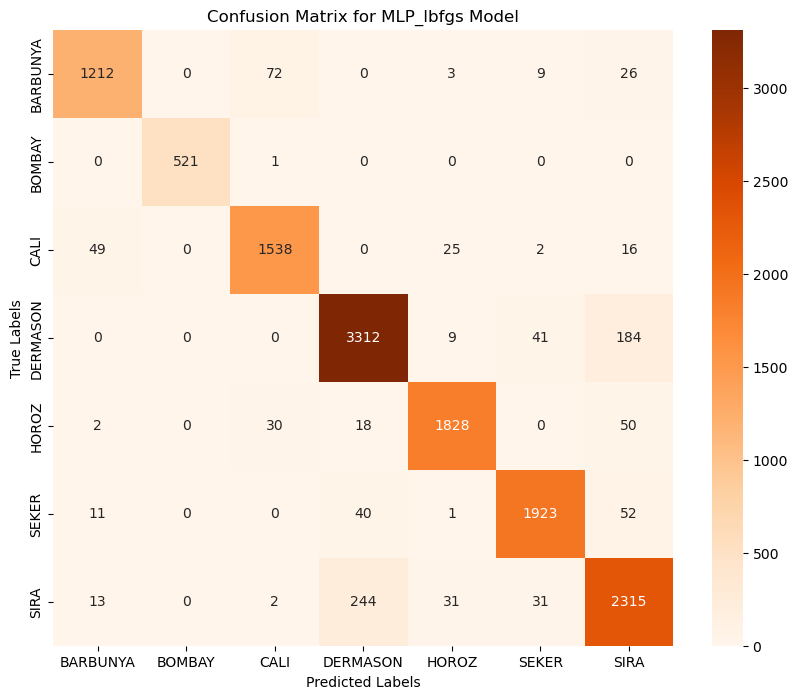

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already calculated the overall confusion matrix for the MLP_lbfgs model
overall_cm = confusion_matrix(results['MLP_lbfgs']['all_true_labels'], results['MLP_lbfgs']['all_predictions'], labels=models['MLP_lbfgs'].classes_)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=models['MLP_lbfgs'].classes_, yticklabels=models['MLP_lbfgs'].classes_)
plt.title('Confusion Matrix for MLP_lbfgs Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



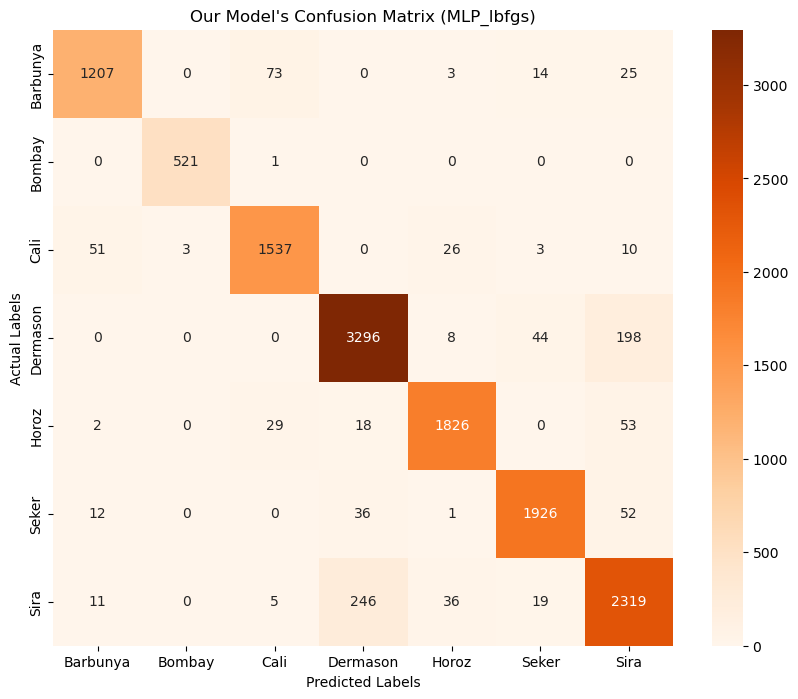

In [13]:
# Your model's confusion matrix data
our_cm_data = [
    [1207, 0, 73, 0, 3, 14, 25],
    [0, 521, 1, 0, 0, 0, 0],
    [51, 3, 1537, 0, 26, 3, 10],
    [0, 0, 0, 3296, 8, 44, 198],
    [2, 0, 29, 18, 1826, 0, 53],
    [12, 0, 0, 36, 1, 1926, 52],
    [11, 0, 5, 246, 36, 19, 2319]
]

classes = ['Barbunya', 'Bombay', 'Cali', 'Dermason', 'Horoz', 'Seker', 'Sira']

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
sns.heatmap(our_cm_data, annot=True, fmt='d', cmap='Oranges', xticklabels=classes, yticklabels=classes, ax=ax)

# Set titles and labels
ax.set_title("Our Model's Confusion Matrix (MLP_lbfgs)")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

plt.show()

# # Save the figure
# fig.savefig('our_model_confusion_matrix_mlp_lbfgs.jpeg', format='jpeg', dpi=600)
# # Close the plot
# plt.close(fig)

# # Convert the confusion matrix data to a DataFrame
# our_cm_df = pd.DataFrame(our_cm_data, index=classes, columns=classes)
# # Save the DataFrame as a CSV file
# our_cm_df.to_csv('our_model_confusion_matrix_mlp_lbfgs.csv')

In [14]:
# sns.heatmap(overall_cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=models['MLP_lbfgs'].classes_, yticklabels=models['MLP_lbfgs'].classes_)


##### Table 8: Confusion Matrix from the Paper

|          | Barbunya | Bombay | Cali | Dermason | Horoz | Seker | Sira |
|----------|----------|--------|------|----------|-------|-------|------|
| Barbunya | 1184     | 4      | 87   | 2        | 3     | 0     | 34   |
| Bombay   | 1        | 518    | 3    | 0        | 0     | 3     | 52   |
| Cali     | 44       | 5      | 1530 | 0        | 34    | 2     | 198  |
| Dermason | 1        | 0      | 0    | 3293     | 2     | 52    | 49   |
| Horoz    | 5        | 0      | 29   | 16       | 1829  | 1     | 64   |
| Seker    | 14       | 0      | 0    | 49       | 0     | 1899  | 26   |
| Sira     | 9        | 0      | 4    | 325      | 40    | 26    | 2232 |


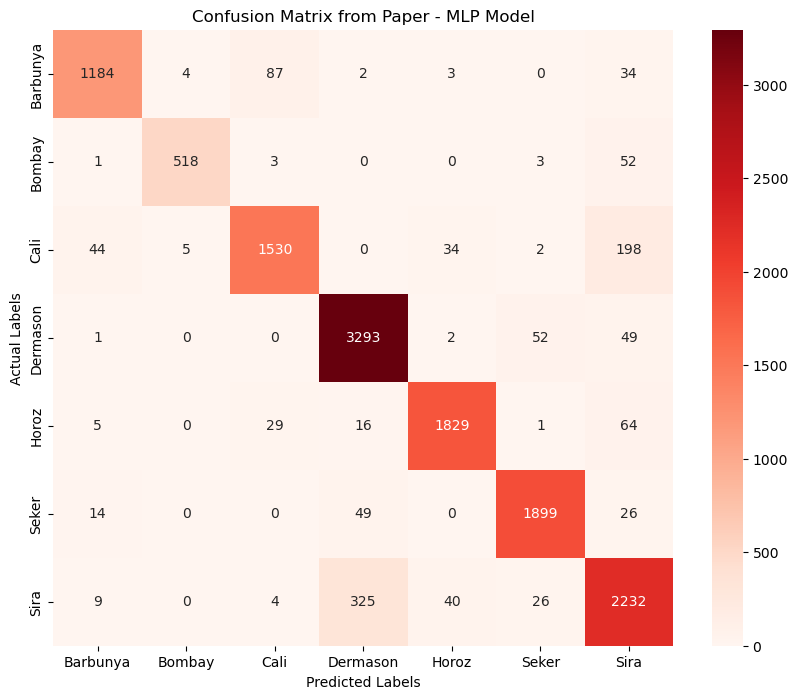

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
cm_data = [
    [1184, 4, 87, 2, 3, 0, 34],
    [1, 518, 3, 0, 0, 3, 52],
    [44, 5, 1530, 0, 34, 2, 198],
    [1, 0, 0, 3293, 2, 52, 49],
    [5, 0, 29, 16, 1829, 1, 64],
    [14, 0, 0, 49, 0, 1899, 26],
    [9, 0, 4, 325, 40, 26, 2232]
]

classes = ['Barbunya', 'Bombay', 'Cali', 'Dermason', 'Horoz', 'Seker', 'Sira']

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
sns.heatmap(cm_data, annot=True, fmt='d', cmap='Reds', xticklabels=classes, yticklabels=classes, ax=ax)

# Set titles and labels
ax.set_title('Confusion Matrix from Paper - MLP Model')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

plt.show()

# # Save the figure
# fig.savefig('mpl_confusion_matrix_paper.jpeg', format='jpeg', dpi=300)
# # Close the plot
# plt.close(fig)

# # Convert the confusion matrix data to a DataFrame
# cm_df = pd.DataFrame(cm_data, index=classes, columns=classes)
# # Save the DataFrame as a CSV file
# cm_df.to_csv('mpl_confusion_matrix_paper.csv')


## More optimized model:

In this section I will use grid search method and increase model complexity to achive better results.

In [16]:
# solvers = ['sgd', 'lbfgs']
# hidden_layer_sizes = [(10, 5, 5), (10, 10, 10), (15, 5, 5), (15, 15, 15)]

# # Combine solvers and hidden layer sizes into a list of configurations
# configurations = [(solver, size) for solver in solvers for size in hidden_layer_sizes]


In [17]:
solvers = ['lbfgs']
hidden_layer_sizes = [(15, 15, 15)]
configurations = [(solver, size) for solver in solvers for size in hidden_layer_sizes]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

results = []

for solver, size in configurations:
    mlp = MLPClassifier(hidden_layer_sizes=size, activation='logistic', solver=solver, 
                        learning_rate_init=0.1, tol=1e-5, max_iter=500000, random_state=1442)

    pipeline = make_pipeline(StandardScaler(), mlp)
    cross_val = StratifiedKFold(n_splits=10, shuffle=True, random_state=1442)

    # Get cross-validated predictions
    y_pred = cross_val_predict(pipeline, features, targets.values.ravel(), cv=cross_val)

    # Compute metrics
    accuracy = accuracy_score(targets, y_pred)
    error_rate = 1 - accuracy
    sensitivity = recall_score(targets, y_pred, average='macro')
    precision = precision_score(targets, y_pred, average='macro', zero_division=0)
    recall = recall_score(targets, y_pred, average='macro')
    f1 = f1_score(targets, y_pred, average='macro')

    results.append({
        'Solver': solver,
        'Hidden_Layer_Size': size,
        'Accuracy': accuracy,
        'Error_Rate': error_rate,
        'Sensitivity': sensitivity,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Example data split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for alpha in alpha_values:
    mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), activation='logistic', solver='adam', 
                        learning_rate_init=0.3, max_iter=1500, alpha=alpha, random_state=42)
    
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Alpha: {alpha} - Accuracy: {accuracy}")


/home/monkeyrampage/miniconda3/envs/minimal_ds/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
results_df = pd.DataFrame(results)

# Format the DataFrame for better readability
formatted_df = results_df.style.format({
    'Accuracy': '{:.2%}',
    'Error_Rate': '{:.2%}',
    'Sensitivity': '{:.2%}',
    'Specificity': '{:.2%}',
    'Precision': '{:.2%}',
    'Recall': '{:.2%}',
    'F1_Score': '{:.2%}'
})

# Display the formatted DataFrame
formatted_df
